In [ ]:
import json
import logging
import os
import random
import re
from pathlib import Path

import evaluate
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BertTokenizerFast, pipeline

from src.eval_lstm import evaluate_rouge
from src.configs import CONFIG, DATA_PATH, PROJECT_PATH, ROUGE
from src.next_token_dataset import LMTextDataset, collate_fn
from src.lstm_model import LSTMLanguageModel
from src.lstm_train import train_model
from src.utils.utils import load_tweets, process_tweets_dataset, split_data

s:\yandex\text-autocomplete\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.__version__

(device(type='cuda'), '2.5.1+cu124')

In [4]:
random.seed(42)
torch.manual_seed(42)

In [5]:
# Загружаем токенизатор
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
# Загружаем и обрабатываем твиты
processed_texts = process_tweets_dataset(
    tokenizer=tokenizer
)

INFO:src.utils.utils:Загружаем обработанные данные из s:\yandex\text-autocomplete\data\processed_tweets.json


In [7]:
print(processed_texts[0])

['user', 'ur', '##l', 'aw', '##w', '##w', ',', 'that', "'", 's', 'a', 'bum', '##mer', '.', 'you', 'should', '##a', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';', 'd']


In [8]:
train_texts, val_texts, test_texts = split_data(
    processed_texts
)

INFO:src.utils.utils:Загружаем разделенные данные из файлов
INFO:src.utils.utils:Загружено: train=1280398, val=160050, test=160050


In [9]:
pad_token_id = tokenizer.pad_token_id or 0  # если у токенизатора нет pad_token, то используем 0

In [10]:
train_dataset = LMTextDataset(train_texts, tokenizer)
val_dataset   = LMTextDataset(val_texts, tokenizer)
test_dataset  = LMTextDataset(test_texts, tokenizer)

batch_size = CONFIG['training']['batch_size']

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, pad_token_id))

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=lambda b: collate_fn(b, pad_token_id))
    
test_loader  = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=lambda b: collate_fn(b, pad_token_id))

Шаг 2

Шаг 3

Использование

In [11]:
vocab_size = tokenizer.vocab_size

Epoch 1/2: 100%|██████████| 40013/40013 [16:20<00:00, 40.81it/s]  
INFO:absl:Using default tokenizer.
INFO:src.lstm_train:Epoch 1: Train Loss=5.4271, Val Loss=4.8823, Val ROUGE-L=0.0294
INFO:src.lstm_train:Сохранена новая лучшая модель (ROUGE-L=0.0294)
INFO:src.lstm_train:Сохранена модель эпохи 1
Epoch 2/2: 100%|██████████| 40013/40013 [18:28<00:00, 36.11it/s]  
INFO:absl:Using default tokenizer.
INFO:src.lstm_train:Epoch 2: Train Loss=4.7885, Val Loss=4.6680, Val ROUGE-L=0.0294
INFO:src.lstm_train:Сохранена новая лучшая модель (ROUGE-L=0.0294)
INFO:src.lstm_train:Сохранена модель эпохи 2
INFO:src.lstm_train:Обучение завершено. Лучший ROUGE-L=0.0294
INFO:src.lstm_train:Лучшая модель сохранена в s:\yandex\text-autocomplete\models\best_model.pt


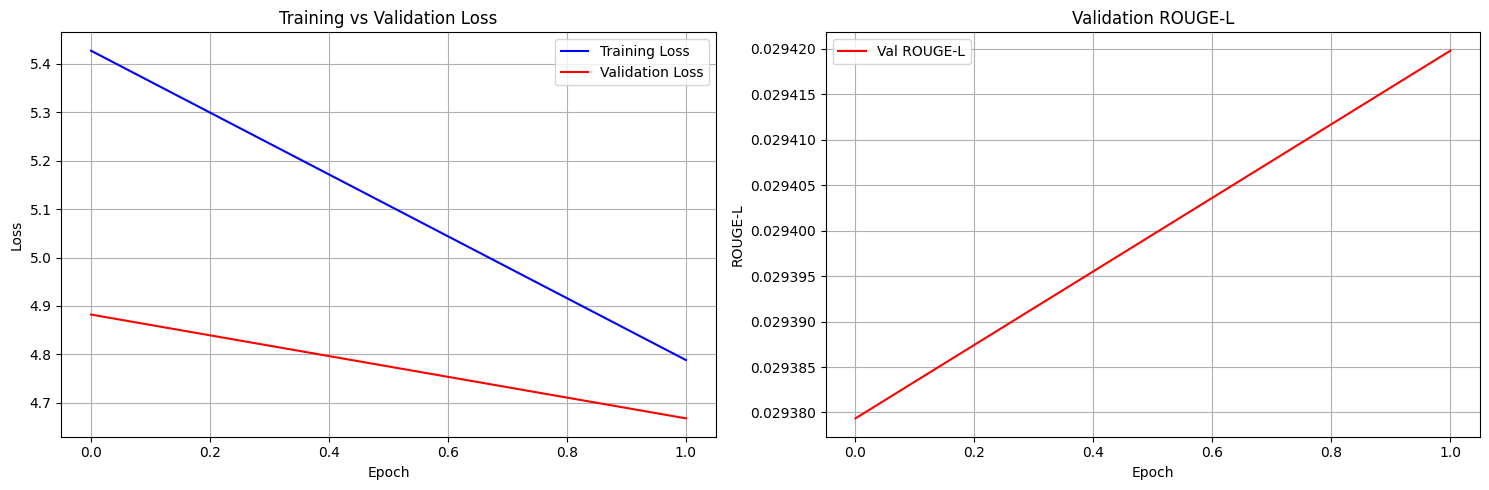

Генерация примера...
Generated: i am feeling now. i am still in bed in my room


C:\Users\gavri\AppData\Local\Temp\ipykernel_32824\1260025172.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_path))


In [13]:

embed_dim = CONFIG['model']['embed_dim']
hidden_dim = CONFIG['model']['hidden_dim']
num_layers = CONFIG['model']['num_layers']

model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    pad_token_id=pad_token_id
)

trained_model, best_path = train_model(
    model, train_loader, val_loader, tokenizer, device,
    epochs=CONFIG['training']['epochs'],
    lr=CONFIG['training']['lr'],
    weight_decay=CONFIG['training']['weight_decay'],
    pad_token_id=pad_token_id
)

# Загружаем лучший чекпойнт
best_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    pad_token_id=pad_token_id
).to(device)
best_model.load_state_dict(torch.load(best_path))

# Генерация примера
print("Генерация примера...")
sample_text = "i am feeling"
input_ids = tokenizer.encode(sample_text, return_tensors="pt").to(device)
print("Generated:", best_model.generate(input_ids, tokenizer, max_new_tokens=10, top_k=20))


In [10]:
# Инициализация предобученной модели distilgpt2
print("Загрузка предобученной модели distilgpt2...")
generator = pipeline("text-generation", model="distilgpt2", device=0 if torch.cuda.is_available() else -1)
distil_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
distil_model = AutoModelForCausalLM.from_pretrained("distilgpt2")

# Добавляем pad_token если его нет
if distil_tokenizer.pad_token is None:
    distil_tokenizer.pad_token = distil_tokenizer.eos_token

print("Модель загружена успешно!")

Загрузка предобученной модели distilgpt2...


Device set to use cuda:0


Модель загружена успешно!


In [43]:
def generate_with_distilgpt2(text, max_new_tokens=20, do_sample=True, top_k=50, top_p=0.95, temperature=1.0):
    """
    Генерация текста с помощью distilgpt2.
    
    Args:
        text (str): Входной контекст.
        max_new_tokens (int): Максимальное количество новых токенов для генерации.
        do_sample (bool): Использовать ли сэмплирование.
        top_k (int): Параметр top-k сэмплирования.
        top_p (float): Параметр top-p (nucleus) сэмплирования.
        temperature (float): Температура сэмплирования.
        
    Returns:
        str: Сгенерированный текст.
    """
    # Подготавливаем параметры генерации
    generation_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "temperature": temperature,
        "pad_token_id": distil_tokenizer.eos_token_id,
        "truncation": True
    }
    
    # Добавляем параметры сэмплирования только если используется сэмплирование
    if do_sample:
        generation_kwargs.update({
            "top_k": top_k,
            "top_p": top_p
        })
    
    result = generator(text, **generation_kwargs)
    return result[0]["generated_text"]

In [23]:
def evaluate_distilgpt2_rouge(val_texts, max_samples=2000, max_new_tokens=20, 
                              do_sample=True, top_k=50, top_p=0.95, temperature=1.0):
    """
    Оценка качества distilgpt2 с помощью метрики ROUGE.
    
    Args:
        val_texts (list): Список валидационных текстов (исходные строки).
        max_samples (int): Максимальное количество примеров для оценки.
        max_new_tokens (int): Максимальное количество новых токенов для генерации.
        do_sample (bool): Использовать ли сэмплирование.
        top_k (int): Параметр top-k сэмплирования.
        top_p (float): Параметр top-p сэмплирования.
        temperature (float): Температура сэмплирования.
        
    Returns:
        dict: Словарь с метриками ROUGE.
    """
    preds, refs = [], []
    processed = 0
    
    print(f"Оценка distilgpt2 на {min(len(val_texts), max_samples)} примерах...")
    
    for i, text in enumerate(tqdm(val_texts[:max_samples])):
        if processed >= max_samples:
            break
            
        # Проверяем, что text - это строка, а не список токенов
        if isinstance(text, list):
            # Если это список токенов, пропускаем этот пример
            continue
            
        # Предобработка текста - получаем строку, а не токены
        processed_text = preprocess_text(text, tokenizer=None)  # Не используем токенизатор
        
        # Теперь токенизируем с помощью distil_tokenizer
        tokens = distil_tokenizer.tokenize(processed_text)
        if len(tokens) < 4:
            continue
            
        # Берем первые 75% как контекст
        cutoff = max(1, int(len(tokens) * 0.75))
        context_tokens = tokens[:cutoff]
        target_tokens = tokens[cutoff:]
        
        if len(target_tokens) == 0:
            continue
            
        # Декодируем контекст
        context_text = distil_tokenizer.convert_tokens_to_string(context_tokens)
        target_text = distil_tokenizer.convert_tokens_to_string(target_tokens)
        
        # Генерируем продолжение
        try:
            generated_text = generate_with_distilgpt2(
                context_text, 
                max_new_tokens=len(target_tokens) + 5,  # Генерируем примерно столько же токенов + небольшой запас
                do_sample=do_sample,
                top_k=top_k,
                top_p=top_p,
                temperature=temperature
            )
            
            # Извлекаем только сгенерированную часть
            generated_continuation = generated_text[len(context_text):].strip()
            
            preds.append(generated_continuation)
            refs.append(target_text)
            processed += 1
            
        except Exception as e:
            print(f"Ошибка при генерации для примера {i}: {e}")
            continue
    
    print(f"Обработано {len(preds)} примеров")
    
    if len(preds) == 0:
        return {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
    
    # Вычисляем ROUGE метрики
    rouge_scores = rouge.compute(predictions=preds, references=refs)
    return rouge_scores

In [24]:
# Создаем валидационную выборку из исходных текстов
print("Создание валидационной выборки из исходных текстов...")

# Загружаем исходные тексты
with open(r'S:\yandex\text-autocomplete\data\tweets.txt', 'r') as file:
    original_tweets = file.readlines()

# Создаем такую же разбивку как для обработанных текстов
train_original, temp_original = train_test_split(original_tweets, test_size=0.2, random_state=42)
val_original, test_original = train_test_split(temp_original, test_size=0.5, random_state=42)

print(f"Исходных текстов: {len(original_tweets)}")
print(f"Валидационных текстов: {len(val_original)}")

Создание валидационной выборки из исходных текстов...
Исходных текстов: 1600498
Валидационных текстов: 160050


In [28]:
rouge = evaluate.load("rouge")
# Подбор параметров генерации (исправленная версия)
print("=== Подбор параметров генерации для distilgpt2 ===")

# Параметры для тестирования
param_configs = [
    {"top_k": 20, "top_p": 0.9, "temperature": 0.8, "name": "Консервативная"},
    {"top_k": 50, "top_p": 0.95, "temperature": 1.0, "name": "Стандартная"},
    {"top_k": 100, "top_p": 0.98, "temperature": 1.2, "name": "Креативная"},
    {"top_k": 10, "top_p": 0.8, "temperature": 0.6, "name": "Осторожная"},
    {"top_k": 200, "top_p": 0.99, "temperature": 1.5, "name": "Экспериментальная"}
]

def extract_rouge_score(rouge_value):
    """
    Извлекает числовое значение ROUGE метрики.
    
    Args:
        rouge_value: Значение ROUGE метрики (может быть объектом с .mid.fmeasure или просто числом).
        
    Returns:
        float: Числовое значение метрики.
    """
    if hasattr(rouge_value, 'mid') and hasattr(rouge_value.mid, 'fmeasure'):
        return rouge_value.mid.fmeasure
    elif hasattr(rouge_value, 'fmeasure'):
        return rouge_value.fmeasure
    else:
        return float(rouge_value)

best_rouge = 0.0
best_config = None
results = []

for config in param_configs:
    print(f"\nТестирование конфигурации: {config['name']}")
    print(f"Параметры: top_k={config['top_k']}, top_p={config['top_p']}, temperature={config['temperature']}")
    
    # Используем val_original
    rouge_scores = evaluate_distilgpt2_rouge(
        val_original,  # Используем исходные тексты
        max_samples=500,  # Меньше примеров для быстрого тестирования
        max_new_tokens=20,
        do_sample=True,
        top_k=config['top_k'],
        top_p=config['top_p'],
        temperature=config['temperature']
    )
    
    # Извлекаем ROUGE scores с помощью универсальной функции
    rouge1 = extract_rouge_score(rouge_scores["rouge1"])
    rouge2 = extract_rouge_score(rouge_scores["rouge2"])
    rouge_l = extract_rouge_score(rouge_scores["rougeL"])
    
    results.append({
        "config": config,
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougeL": rouge_l
    })
    
    print(f"ROUGE-1: {rouge1:.4f}")
    print(f"ROUGE-2: {rouge2:.4f}")
    print(f"ROUGE-L: {rouge_l:.4f}")
    
    if rouge_l > best_rouge:
        best_rouge = rouge_l
        best_config = config

print(f"\n🏆 Лучшая конфигурация: {best_config['name']}")
print(f"Лучший ROUGE-L: {best_rouge:.4f}")

=== Подбор параметров генерации для distilgpt2 ===

Тестирование конфигурации: Консервативная
Параметры: top_k=20, top_p=0.9, temperature=0.8
Оценка distilgpt2 на 500 примерах...


100%|██████████| 500/500 [00:36<00:00, 13.75it/s]


Обработано 491 примеров
ROUGE-1: 0.0489
ROUGE-2: 0.0035
ROUGE-L: 0.0477

Тестирование конфигурации: Стандартная
Параметры: top_k=50, top_p=0.95, temperature=1.0
Оценка distilgpt2 на 500 примерах...


100%|██████████| 500/500 [00:33<00:00, 14.89it/s]


Обработано 491 примеров
ROUGE-1: 0.0460
ROUGE-2: 0.0067
ROUGE-L: 0.0443

Тестирование конфигурации: Креативная
Параметры: top_k=100, top_p=0.98, temperature=1.2
Оценка distilgpt2 на 500 примерах...


100%|██████████| 500/500 [00:32<00:00, 15.23it/s]


Обработано 491 примеров
ROUGE-1: 0.0337
ROUGE-2: 0.0016
ROUGE-L: 0.0331

Тестирование конфигурации: Осторожная
Параметры: top_k=10, top_p=0.8, temperature=0.6
Оценка distilgpt2 на 500 примерах...


100%|██████████| 500/500 [00:32<00:00, 15.47it/s]


Обработано 491 примеров
ROUGE-1: 0.0615
ROUGE-2: 0.0092
ROUGE-L: 0.0603

Тестирование конфигурации: Экспериментальная
Параметры: top_k=200, top_p=0.99, temperature=1.5
Оценка distilgpt2 на 500 примерах...


100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


Обработано 491 примеров
ROUGE-1: 0.0239
ROUGE-2: 0.0007
ROUGE-L: 0.0231

🏆 Лучшая конфигурация: Осторожная
Лучший ROUGE-L: 0.0603


In [29]:
# Оценка на полной валидационной выборке с лучшими параметрами
print(f"\n=== Финальная оценка с лучшими параметрами ===")
print(f"Используем конфигурацию: {best_config['name']}")

final_rouge_scores = evaluate_distilgpt2_rouge(
    val_original, 
    max_samples=2000,
    max_new_tokens=20,
    do_sample=True,
    top_k=best_config['top_k'],
    top_p=best_config['top_p'],
    temperature=best_config['temperature']
)

# Извлекаем финальные ROUGE scores
final_rouge1 = extract_rouge_score(final_rouge_scores['rouge1'])
final_rouge2 = extract_rouge_score(final_rouge_scores['rouge2'])
final_rouge_l = extract_rouge_score(final_rouge_scores['rougeL'])

print(f"\n📊 Финальные результаты distilgpt2:")
print(f"ROUGE-1: {final_rouge1:.4f}")
print(f"ROUGE-2: {final_rouge2:.4f}")
print(f"ROUGE-L: {final_rouge_l:.4f}")


=== Финальная оценка с лучшими параметрами ===
Используем конфигурацию: Осторожная
Оценка distilgpt2 на 2000 примерах...


100%|██████████| 2000/2000 [02:13<00:00, 15.00it/s]


Обработано 1974 примеров

📊 Финальные результаты distilgpt2:
ROUGE-1: 0.0629
ROUGE-2: 0.0078
ROUGE-L: 0.0621


In [31]:
# Примеры предсказаний
print("\n=== Примеры предсказаний distilgpt2 ===")

# Выбираем несколько примеров из валидационной выборки
sample_indices = [0, 10, 50, 100, 200]
sample_texts = [val_original[i] for i in sample_indices if i < len(val_original)]

for i, text in enumerate(sample_texts):
    print(f"\n--- Пример {i+1} ---")
    
    # Предобработка - получаем строку, а не токены
    processed_text = preprocess_text(text, tokenizer=None)  # Не используем токенизатор
    tokens = distil_tokenizer.tokenize(processed_text)
    
    if len(tokens) < 4:
        continue
        
    # Разбиваем на контекст и цель
    cutoff = max(1, int(len(tokens) * 0.75))
    context_tokens = tokens[:cutoff]
    target_tokens = tokens[cutoff:]
    
    context_text = distil_tokenizer.convert_tokens_to_string(context_tokens)
    target_text = distil_tokenizer.convert_tokens_to_string(target_tokens)
    
    print(f"Исходный текст: {text[:100]}...")
    print(f"Контекст: {context_text}")
    print(f"Ожидаемое продолжение: {target_text}")
    
    # Генерируем с лучшими параметрами
    try:
        generated_text = generate_with_distilgpt2(
            context_text,
            max_new_tokens=len(target_tokens) + 5,  # Используем max_new_tokens вместо max_length
            do_sample=True,
            top_k=best_config['top_k'],
            top_p=best_config['top_p'],
            temperature=best_config['temperature']
        )
        
        generated_continuation = generated_text[len(context_text):].strip()
        print(f"Сгенерированное продолжение: {generated_continuation}")
        
    except Exception as e:
        print(f"Ошибка при генерации: {e}")


=== Примеры предсказаний distilgpt2 ===

--- Пример 1 ---
Исходный текст: @mgatton nice hair cut!  dude why were your students leaving in the middle of class, 1st period?
...
Контекст: <user> nice hair cut! dude why were your students leaving in the middle of
Ожидаемое продолжение:  class, 1st period?
Сгенерированное продолжение: the night?

--- Пример 2 ---
Исходный текст: Just packed my stethoscope 
...
Контекст: just packed my st
Ожидаемое продолжение: ethoscope
Сгенерированное продолжение: roller with a bunch of friends and

--- Пример 3 ---
Исходный текст: I couldn't go to the Revlon Run Walk today because my formerly broken ankle is throbbing.  
...
Контекст: i couldn't go to the revlon run walk today because my formerly broken
Ожидаемое продолжение:  ankle is throbbing.
Сгенерированное продолжение: leg was not in the running game. I was

--- Пример 4 ---
Исходный текст: too much ice cream! 
...
Контекст: too much ice
Ожидаемое продолжение:  cream!
Сгенерированное продолжение: .

In [ ]:
# Загрузка лучшей LSTM модели из чекпоинта (как в оригинальном коде)
print("Загрузка лучшей LSTM модели из чекпоинта...")

# Путь к лучшей модели
best_path = r"S:\yandex\deep_learning_s_1\checkpoints\best_model.pt"

# Создаем экземпляр модели с теми же параметрами
best_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=256,
    hidden_dim=256,
    num_layers=3,
    pad_token_id=pad_token_id
).to(device)

# Загружаем веса модели
best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()

print("✅ Модель успешно загружена!")
print(f"Путь к модели: {best_path}")

# Тестируем загруженную модель
print("\n🧪 Тестирование загруженной модели...")
test_input = "i am feeling"
input_ids = tokenizer.encode(test_input, return_tensors="pt").to(device)
generated_text = best_model.generate(input_ids, tokenizer, max_new_tokens=10, top_k=20)
print(f"Тестовый ввод: {test_input}")
print(f"Сгенерированный текст: {generated_text}")

Загрузка лучшей LSTM модели из чекпоинта...
✅ Модель успешно загружена!
Путь к модели: S:\yandex\deep_learning_s_1\checkpoints\best_model.pt

🧪 Тестирование загруженной модели...
Тестовый ввод: i am feeling
Сгенерированный текст: i am feeling. no more... i just don '


C:\Users\gavri\AppData\Local\Temp\ipykernel_12148\3884275345.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_path, map_locati

In [ ]:
# Сравнение с LSTM моделью
print("\n=== Сравнение distilgpt2 с LSTM ===")

# Оценка LSTM на валидационной выборке
print("Оценка LSTM модели...")
lstm_rouge_scores = evaluate_rouge(
    model=best_model,
    dataloader=val_loader,
    tokenizer=tokenizer,
    device=device
)

# Извлекаем LSTM ROUGE scores
lstm_rouge1 = extract_rouge_score(lstm_rouge_scores['rouge1'])
lstm_rouge2 = extract_rouge_score(lstm_rouge_scores['rouge2'])
lstm_rouge_l = extract_rouge_score(lstm_rouge_scores['rougeL'])

print(f"\n�� Сравнение результатов:")
print(f"{'Модель':<15} {'ROUGE-1':<10} {'ROUGE-2':<10} {'ROUGE-L':<10}")
print("-" * 50)
print(f"{'LSTM':<15} {lstm_rouge1:.4f}     {lstm_rouge2:.4f}     {lstm_rouge_l:.4f}")
print(f"{'distilgpt2':<15} {final_rouge1:.4f}     {final_rouge2:.4f}     {final_rouge_l:.4f}")

# Определяем лучшую модель
if final_rouge_l > lstm_rouge_l:
    print(f"\n�� distilgpt2 показывает лучшие результаты (ROUGE-L: {final_rouge_l:.4f} vs {lstm_rouge_l:.4f})")
else:
    print(f"\n�� LSTM показывает лучшие результаты (ROUGE-L: {lstm_rouge_l:.4f} vs {final_rouge_l:.4f})")


=== Сравнение distilgpt2 с LSTM ===
Оценка LSTM модели...

�� Сравнение результатов:
Модель          ROUGE-1    ROUGE-2    ROUGE-L   
--------------------------------------------------
LSTM            0.0359     0.0016     0.0356
distilgpt2      0.0629     0.0078     0.0621

�� distilgpt2 показывает лучшие результаты (ROUGE-L: 0.0621 vs 0.0356)


In [45]:
# Дополнительные эксперименты с параметрами
print("\n=== Дополнительные эксперименты ===")

# Тестирование без сэмплирования (жадный поиск)
print("Тестирование жадного поиска (без сэмплирования)...")
greedy_rouge = evaluate_distilgpt2_rouge(
    val_original[:500], 
    max_samples=500,
    max_new_tokens=20,
    do_sample=False,  # Жадный поиск
    top_k=1,
    top_p=1.0,
    temperature=1.0
)

greedy_rouge_l = extract_rouge_score(greedy_rouge['rougeL'])
print(f"Жадный поиск ROUGE-L: {greedy_rouge_l:.4f}")

# Тестирование с разными температурами
print("\nТестирование разных температур...")
temperatures = [0.1, 0.3, 0.5, 0.8, 1.0, 1.2, 1.5]
temp_results = []

for temp in temperatures:
    temp_rouge = evaluate_distilgpt2_rouge(
        val_original[:300], 
        max_samples=300,
        max_new_tokens=20,
        do_sample=True,
        top_k=best_config['top_k'],
        top_p=best_config['top_p'],
        temperature=temp
    )
    temp_rouge_l = extract_rouge_score(temp_rouge['rougeL'])
    temp_results.append({
        'temperature': temp,
        'rouge_l': temp_rouge_l
    })
    print(f"Температура {temp}: ROUGE-L = {temp_rouge_l:.4f}")

# Найдем лучшую температуру
best_temp_result = max(temp_results, key=lambda x: x['rouge_l'])
print(f"\n�� Лучшая температура: {best_temp_result['temperature']} (ROUGE-L: {best_temp_result['rouge_l']:.4f})")


=== Дополнительные эксперименты ===
Тестирование жадного поиска (без сэмплирования)...
Оценка distilgpt2 на 500 примерах...


100%|██████████| 500/500 [00:29<00:00, 16.87it/s]


Обработано 491 примеров
Жадный поиск ROUGE-L: 0.0696

Тестирование разных температур...
Оценка distilgpt2 на 300 примерах...


100%|██████████| 300/300 [00:20<00:00, 14.94it/s]


Обработано 295 примеров
Температура 0.1: ROUGE-L = 0.0821
Оценка distilgpt2 на 300 примерах...


100%|██████████| 300/300 [00:19<00:00, 15.36it/s]


Обработано 295 примеров
Температура 0.3: ROUGE-L = 0.0861
Оценка distilgpt2 на 300 примерах...


100%|██████████| 300/300 [00:19<00:00, 15.40it/s]


Обработано 295 примеров
Температура 0.5: ROUGE-L = 0.0787
Оценка distilgpt2 на 300 примерах...


100%|██████████| 300/300 [00:19<00:00, 15.78it/s]


Обработано 295 примеров
Температура 0.8: ROUGE-L = 0.0648
Оценка distilgpt2 на 300 примерах...


100%|██████████| 300/300 [00:19<00:00, 15.67it/s]


Обработано 295 примеров
Температура 1.0: ROUGE-L = 0.0570
Оценка distilgpt2 на 300 примерах...


100%|██████████| 300/300 [00:19<00:00, 15.61it/s]


Обработано 295 примеров
Температура 1.2: ROUGE-L = 0.0615
Оценка distilgpt2 на 300 примерах...


100%|██████████| 300/300 [00:19<00:00, 15.44it/s]


Обработано 295 примеров
Температура 1.5: ROUGE-L = 0.0521

�� Лучшая температура: 0.3 (ROUGE-L: 0.0861)


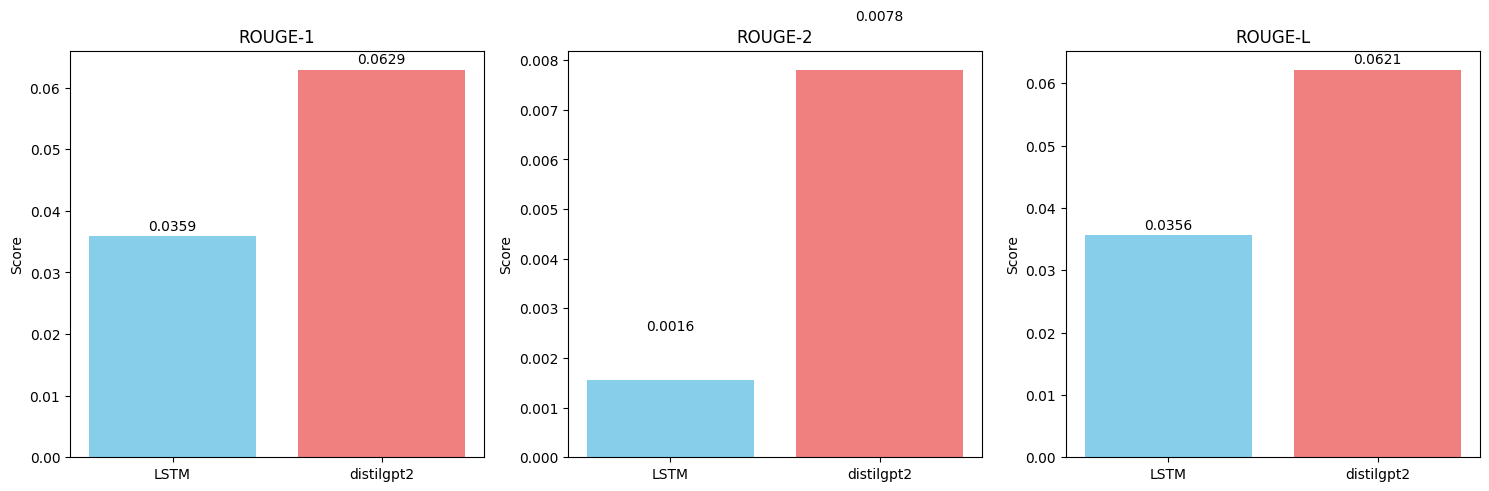

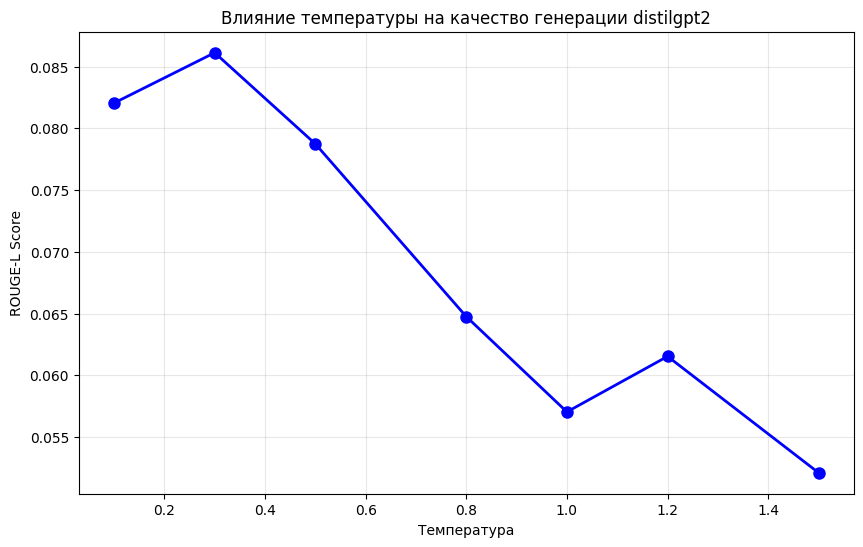

In [46]:
# График сравнения ROUGE метрик
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ['LSTM', 'distilgpt2']
rouge1_scores = [lstm_rouge1, final_rouge1]
rouge2_scores = [lstm_rouge2, final_rouge2]
rougeL_scores = [lstm_rouge_l, final_rouge_l]

axes[0].bar(models, rouge1_scores, color=['skyblue', 'lightcoral'])
axes[0].set_title('ROUGE-1')
axes[0].set_ylabel('Score')
for i, v in enumerate(rouge1_scores):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center')

axes[1].bar(models, rouge2_scores, color=['skyblue', 'lightcoral'])
axes[1].set_title('ROUGE-2')
axes[1].set_ylabel('Score')
for i, v in enumerate(rouge2_scores):
    axes[1].text(i, v + 0.001, f'{v:.4f}', ha='center')

axes[2].bar(models, rougeL_scores, color=['skyblue', 'lightcoral'])
axes[2].set_title('ROUGE-L')
axes[2].set_ylabel('Score')
for i, v in enumerate(rougeL_scores):
    axes[2].text(i, v + 0.001, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# График влияния температуры
plt.figure(figsize=(10, 6))
temps = [r['temperature'] for r in temp_results]
scores = [r['rouge_l'] for r in temp_results]
plt.plot(temps, scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Температура')
plt.ylabel('ROUGE-L Score')
plt.title('Влияние температуры на качество генерации distilgpt2')
plt.grid(True, alpha=0.3)
plt.show()